# Analysis & Visualization of Pan-genome tool benchmarking - Mtb-151CI dataset

### Maximillian Marin (mgmarin@g.harvard.edu)

### Import Statements

In [66]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [67]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [68]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [69]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Set matplotlib text export settings for Adobe Illustrator

In [70]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Parse sample metadata & preprocessed genome info/results

## Parse sample Metadata (N = 151)

In [71]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

In [72]:
High_SRBusco_SampleIDs_143CI = ['N0072', 'N0153', 'DNA028', 'N0155', 'N0145', 'DNA075',
       'M0003941_3', 'DNA019_Vash', 'DNA091', 'DNA096', 'AZE_02_067',
       'AZE_02_041', 'ZRB10578980', 'DNA089', 'N0004', 'N1274', 'N0054',
       'DNA124', 'DNA044', 'DNA020', 'AZE_02_042', 'DNA182', 'DNA120',
       'DNA188', 'DNA086', 'M0011368_9', 'MT_0080', 'M0016737_0',
       'DNA054', 'M0014888_3', '02_R1179', '01_R1134', 'M0017522_5',
       'M0016395_7', '02_R1708', '02_R0894', '01_R1430', 'M0010874_7',
       'N1272', 'N0091', 'N1202', '9050-05', '4549-04', '696-05',
       '702-06', '706-05', '8129-04', '3003-06', '8651-04', 'QC-3',
       'QC-9', 'QC-5', 'QC-8', 'QC-10', 'QC-4', 'QC-6', 'QC-1', '8644-04',
       'mada_1-10', 'mada_2-46', 'mada_1-1', 'mada_1-36', 'mada_1-39',
       'mada_1-40', 'mada_1-51', 'mada_1-44', 'mada_117', 'mada_118',
       'mada_122', 'R27252', 'R23887', 'R30078', 'R29816', 'R30234',
       '18_0621851', 'R36431', 'R28703', 'mada_115', 'mada_2-42',
       'R31095', 'R28012', 'R37765', 'R27657', 'R24120', 'R28581',
       'R29598', 'mada_1-11', 'R24100', 'R20574', 'R20260', 'R18043',
       'R22601', 'R23146', 'R32929', 'R21893', 'R30420', 'R26778',
       'R26791', 'R28980', 'R27725', 'R18040', 'R27937', 'mada_1-30',
       'mada_2-31', 'mada_1-41', 'R21839', 'mada_1-32', 'R30396',
       'R21363', 'mada_102', 'mada_129', 'mada_139', 'mada_151',
       'mada_105', 'R15311', 'mada_103', 'mada_2-25', 'mada_112',
       'mada_124', 'mada_126', 'mada_120', 'R23571', 'mada_128',
       'mada_1-12', 'mada_1-15', 'mada_1-2', 'mada_2-1', 'mada_1-53',
       'mada_1-50', 'mada_123', 'mada_2-53', 'MFS-3', 'MFS-59', 'MFS-173',
       'MFS-54', 'MFS-58', 'MFS-51', 'MFS-42', 'MFS-52', 'MFS-56',
       'MFS-60', 'MFS-61', 'MFS-181']

In [73]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [74]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Content_TXT, verbose = False):
    if verbose:
        print(f"reading Ppangolin stats from {i_Ppanggolin_Content_TXT}")
        
    with open(i_Ppanggolin_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            print(line)
            line_split = line.split(": ")

            Key = line_split[0].split(" ")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)
        print(NumShellGenes, NumCloudGenes)
        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

        print(NumCoreGenes, NumAccessoryGenes, NumTotalGenes)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [75]:
# Define pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

# 1) Read in PG stats for Mtb-151CI dataset (Already processed)

In [76]:
PG_Results_OutDir = "../../Data/240116.PG_Results" 

Merged_PG_Stats_Mtb15CI_TSV = f"{PG_Results_OutDir}/Mtb151CI.PG_Merged_Stats_LRandSR.tsv"


In [77]:
PG_Merged_Stats_LRandSR_DF = pd.read_csv(Merged_PG_Stats_Mtb15CI_TSV, sep="\t")
PG_Merged_Stats_LRandSR_DF.shape

(132, 11)

In [78]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
1,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
2,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
3,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [79]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [80]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [81]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [82]:
PG_Merged_Stats_LRandSR_Acc_Bakta_DF = PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta'") 
PG_Merged_Stats_LRandSR_Acc_PGAP_DF = PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'PGAP'") 

In [83]:
#PG_Merged_Stats_LRandSR_DF[ PG_Merged_Stats_LRandSR_DF["Method"].str.contains("Ppanggolin") ].query("Category == 'Accessory genes' ") 

# 2) Create Pan-genome summary table - Wide version 

This table will have pangenome predictions (Total, Core, and Accessory genes) across all methods + technologies.

In [84]:

MethodValues_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                 'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default' ] #'Ppanggolin_I90', 'Ppanggolin_I95',]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs)', 'Panaroo (Moderate & MergeParalogs)',
                 'Panaroo (Sensitive & MergeParalogs)', 'Panaroo (Strict)',
                 'Panaroo (Moderate)', 'Panaroo (Sensitive)',  'Roary (MergeParalogs & I80)', 'Roary (MergeParalogs & I90)',
                 'Roary (MergeParalogs)', 'Roary (Default)', 'Ppanggolin (Default)' ] #'Ppanggolin (I90)', 'Ppanggolin (I95)']


dictOfValues_To_Label = {}  

for i in range(len(MethodValues_X)):
        
    dictOfValues_To_Label[MethodValues_X[i]]   =   Plot_TickLabels[i]


In [85]:
dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo (Strict)',
 'Panaroo_Moderate': 'Panaroo (Moderate)',
 'Panaroo_Sensitive': 'Panaroo (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
 'Roary_Default': 'Roary (Default)',
 'Ppanggolin_Default': 'Ppanggolin (Default)'}

In [86]:

PGCombos_orderToPlot = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default',] #'Ppanggolin_I95', 'Ppanggolin_I90' ]

PGCombos_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
                 'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)',  'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)', 'Ppanggolin \n (Default)',]
                 # 'Ppanggolin \n (I95)', 'Ppanggolin \n (I90)',]

PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PGCombos_orderToPlot)):
        
    PGCombos_dictOfValues_To_Label[MethodValues_X[i]]   =   Plot_TickLabels[i]
    

# dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
#                          'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
#                          'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
#                          'Panaroo_Strict': 'Panaroo (Strict)',
#                          'Panaroo_Moderate': 'Panaroo (Moderate)',
#                          'Panaroo_Sensitive': 'Panaroo (Sensitive)',
#                          'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
#                          'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
#                          'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
#                          'Roary_Default': 'Roary (Default)',
#                          'Ppanggolin_Default': 'Ppanggolin (Default)',
#                          'Ppanggolin_I90': 'Ppanggolin (I90)',
#                          'Ppanggolin_I95': 'Ppanggolin (I95)',}


In [87]:
dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo (Strict)',
 'Panaroo_Moderate': 'Panaroo (Moderate)',
 'Panaroo_Sensitive': 'Panaroo (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
 'Roary_Default': 'Roary (Default)',
 'Ppanggolin_Default': 'Ppanggolin (Default)'}

### Pivot table to get summary per Method and Seqtype

In [88]:
#PG_Merged_Stats_LRandSR_DF.head(2)

In [89]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTechAndAnno"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


PG_WideSumm_DF["SeqType"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-2]
PG_WideSumm_DF["Anno"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-1]
PG_WideSumm_DF["Method"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.replace("_LongRead", "").str.replace("_ShortRead", "").str.replace("_Bakta", "").str.replace("_PGAP", "")       
PG_WideSumm_DF["PangenomeTool"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[0:1].str[0]

# Do some reformatting 
NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_DF = PG_WideSumm_DF[NewColOrder]

PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["SeqType", "PangenomeTool", "Accessory genes"]).reset_index(drop=True)

In [90]:
PG_WideSumm_DF.head(6)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,PGAP,Panaroo_Strict_MergeParalogs,4063,3750,313
1,Panaroo,LongRead,PGAP,Panaroo_Moderate_MergeParalogs,4128,3792,336
2,Panaroo,LongRead,PGAP,Panaroo_Sensitive_MergeParalogs,4128,3792,336
3,Panaroo,LongRead,PGAP,Panaroo_Strict,4118,3761,357
4,Panaroo,LongRead,PGAP,Panaroo_Moderate,4184,3803,381
5,Panaroo,LongRead,PGAP,Panaroo_Sensitive,4184,3803,381


In [91]:


PG_WideSumm_DF = PG_WideSumm_DF.sort_values("Method",
                                            key=lambda x: pd.Categorical(x, categories=PGCombos_orderToPlot, ordered=True))
#PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"], key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))

PG_WideSumm_V2_DF = PG_WideSumm_DF.copy()

PG_WideSumm_V2_DF["Method"] = PG_WideSumm_V2_DF["Method"].replace(dictOfValues_To_Label)

NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [92]:
# PG_WideSumm_V2_DF_Trim

In [93]:
PG_WideSumm_DF["Method"].value_counts()  

Panaroo_Strict_MergeParalogs       4
Panaroo_Moderate_MergeParalogs     4
Panaroo_Sensitive_MergeParalogs    4
Panaroo_Strict                     4
Panaroo_Moderate                   4
Panaroo_Sensitive                  4
Roary_NoSplitParalogs_I80          4
Roary_NoSplitParalogs_I90          4
Roary_NoSplitParalogs              4
Roary_Default                      4
Ppanggolin_Default                 4
Name: Method, dtype: int64

In [94]:
PG_WideSumm_V2_DF_Trim["Method"].value_counts()  

Panaroo (Strict & MergeParalogs)       4
Panaroo (Moderate & MergeParalogs)     4
Panaroo (Sensitive & MergeParalogs)    4
Panaroo (Strict)                       4
Panaroo (Moderate)                     4
Panaroo (Sensitive)                    4
Roary (MergeParalogs & I80)            4
Roary (MergeParalogs & I90)            4
Roary (MergeParalogs)                  4
Roary (Default)                        4
Ppanggolin (Default)                   4
Name: Method, dtype: int64

# Plotting key figures (For SR vs LR & Bakta vs PGAP & 3 pipelines)

In [95]:
PG_WideSumm_V2_DF.shape

(44, 7)

In [98]:
PG_WideSumm_V2_DF.describe()

,Total genes,Core genes,Accessory genes
count,44.000000,44.000000,44.000000
mean,4374.000000,3529.522727,844.477273
std,407.617753,270.578406,537.800754
min,3829.000000,2868.000000,220.000000
25%,4128.000000,3346.500000,502.500000
50%,4266.000000,3555.500000,680.500000
75%,4437.000000,3761.750000,1073.250000
max,6006.000000,3833.000000,2912.000000


#### Overall PG Stats
Total: 3829 - 6006 <br>
Accessory: 220 - 1867 <br>
Core: 3305 - 3833<br>


In [32]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno"]).describe()

Total genes                                                                  Core genes                                                                  Accessory genes                                                               
                      count         mean         std     min     25%     50%     75%     max      count         mean         std     min     25%     50%     75%     max           count         mean         std    min    25%     50%     75%     max
SeqType   Anno                                                                                                                                                                                                                                         
LongRead  Bakta        11.0  4425.000000  326.088638  4200.0  4280.5  4305.0  4387.5  5366.0       11.0  3754.363636   96.647062  3499.0  3719.5  3779.0  3825.0  3833.0            11.0   670.636364  409.824907  421.0  487.0   554.0   610.0  1867.0
          PGAP         11.0  4132.636364  144.998119  3866.0  4084.5  4128.0  4164.0  4482.0       11.0  3607.363636  221.656163  3305.0  3346.0  3750.0  3792.0  3803.0            11.0   525.272727  295.514159  220.0  336.0   381.0   735.0  1177.0
ShortRead Bakta        11.0  4754.000000  513.164496  4211.0  4391.0  4626.0  4977.0  6006.0       11.0  3463.545455  172.164087  3094.0  3325.0  3537.0  3575.0  3663.0            11.0  1290.454545  656.120471  674.0  817.0  1050.0  1586.0  2912.0
          PGAP         11.0  4184.363636  241.696617  3829.0  4044.0  4144.0  4282.5  4713.0       11.0  3292.818182  313.061917  2868.0  2911.0  3489.0  3531.0  3536.0            11.0   891.545455  437.450195  315.0  580.0   858.0  1169.5  1845.0

In [34]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno", "PangenomeTool"]).count()

Method  Total genes  Core genes  Accessory genes
SeqType   Anno  PangenomeTool                                                  
LongRead  Bakta Panaroo             6            6           6                6
                Ppanggolin          1            1           1                1
                Roary               4            4           4                4
          PGAP  Panaroo             6            6           6                6
                Ppanggolin          1            1           1                1
                Roary               4            4           4                4
ShortRead Bakta Panaroo             6            6           6                6
                Ppanggolin          1            1           1                1
                Roary               4            4           4                4
          PGAP  Panaroo             6            6           6                6
                Ppanggolin          1            1           1                1
                Roary               4            4           4                4

In [35]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno", "PangenomeTool"]).median()

Total genes  Core genes  Accessory genes
SeqType   Anno  PangenomeTool                                          
LongRead  Bakta Panaroo             4293.0      3825.0            487.0
                Ppanggolin          4557.0      3764.0            793.0
                Roary               4329.5      3715.0            610.0
          PGAP  Panaroo             4128.0      3792.0            346.5
                Ppanggolin          3866.0      3646.0            220.0
                Roary               4125.0      3341.0            784.0
ShortRead Bakta Panaroo             4391.0      3574.0            817.0
                Ppanggolin          4998.0      3663.0           1335.0
                Roary               4990.5      3321.0           1668.5
          PGAP  Panaroo             4159.0      3531.0            628.0
                Ppanggolin          3829.0      3514.0            315.0
                Roary               4125.0      2907.5           1217.5

In [36]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno", "PangenomeTool"]).mean() 

Total genes   Core genes  Accessory genes
SeqType   Anno  PangenomeTool                                           
LongRead  Bakta Panaroo        4306.833333  3813.666667       493.166667
                Ppanggolin     4557.000000  3764.000000       793.000000
                Roary          4569.250000  3663.000000       906.250000
          PGAP  Panaroo        4134.166667  3783.500000       350.666667
                Ppanggolin     3866.000000  3646.000000       220.000000
                Roary          4197.000000  3333.500000       863.500000
ShortRead Bakta Panaroo        4407.166667  3562.333333       844.833333
                Ppanggolin     4998.000000  3663.000000      1335.000000
                Roary          5213.250000  3265.500000      1947.750000
          PGAP  Panaroo        4196.833333  3518.666667       678.166667
                Ppanggolin     3829.000000  3514.000000       315.000000
                Roary          4254.500000  2898.750000      1355.750000

In [100]:
PG_WideSumm_V2_DF.groupby(["SeqType"]).describe()["Total genes"]

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,22.0,4278.818182,288.155321,3866.0,4128.00,4226.0,4350.75,5366.0
ShortRead,22.0,4469.181818,488.058411,3829.0,4144.75,4388.0,4691.25,6006.0


In [101]:
PG_WideSumm_V2_DF.groupby(["SeqType"]).describe()["Accessory genes"]

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,22.0,597.954545,356.508796,220.0,381.00,528.0,694.25,1867.0
ShortRead,22.0,1091.000000,581.204578,315.0,677.25,955.0,1311.00,2912.0


In [52]:
PG_WideSumm_V2_DF.groupby(["SeqType"]).describe()["Core genes"]

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,22.0,3680.863636,183.039235,3305.0,3663.0,3762.5,3800.25,3833.0
ShortRead,22.0,3378.181818,261.569919,2868.0,3319.5,3522.5,3537.00,3663.0


#### Comparing range of stats between LR vs SR
Long Read - Accessory: 220 - 1867 <br>
Long Read - Core: 3305 - 3833<br>

Short Read - Accessory: 315 - 2912<br>
Short Read - Core: 2868 - 3663<br>

In [53]:
PG_WideSumm_V2_DF.groupby(["Anno"]).describe()["Accessory genes"]

,count,mean,std,min,25%,50%,75%,max
Anno,,,,,,,,
Bakta,22.0,980.545455,620.961829,421.0,554.25,740.0,1263.75,2912.0
PGAP,22.0,708.409091,409.690320,220.0,363.00,628.0,879.00,1845.0


In [54]:
PG_WideSumm_V2_DF.groupby(["Anno"]).describe()["Core genes"]

,count,mean,std,min,25%,50%,75%,max
Anno,,,,,,,,
Bakta,22.0,3608.954545,201.774857,3094.0,3537.0,3619.5,3775.25,3833.0
PGAP,22.0,3450.090909,309.804533,2868.0,3339.0,3522.5,3724.00,3803.0


#### Comparing range of stats between Bakta vs PGAP
Bakta - Accessory: 421 - 2912 <br>
Bakta - Core: 3094 - 3833 <br>

PGAP - Accessory: 220 - 1845 <br>
PGAP - Core: 2868 - 3803 <br>

In [58]:
PG_WideSumm_V2_DF.groupby(["Anno"]).mean()

,Total genes,Core genes,Accessory genes
SeqType,,,
LongRead,4278.818182,3680.863636,597.954545
ShortRead,4469.181818,3378.181818,1091.000000


In [48]:
4589.5 - 4158.5 

431.0

In [47]:
980.545455 - 708.409091

272.13636399999996

In [59]:
PG_WideSumm_V2_DF.groupby(["SeqType"]).mean()

,Total genes,Core genes,Accessory genes
SeqType,,,
LongRead,4278.818182,3680.863636,597.954545
ShortRead,4469.181818,3378.181818,1091.000000


In [60]:
1091 - 597.954545

493.04545499999995

In [61]:
3680.863636 - 3378.181818

302.681818

In [43]:
Z = np.array([1, 4, 8 , 10])
B =  np.array([2, 5, 10, 13])

In [40]:
np.mean(Z)

5.75

In [41]:
np.mean(B)

7.5

In [44]:
7.5 - 5.75

1.75

In [46]:
np.mean(B - Z)

1.75

### What are the most and least conservative estimates for accessory genome size?

In [64]:
PG_WideSumm_V2_DF.sort_values("Accessory genes").head(3)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
12,Ppanggolin,LongRead,PGAP,Ppanggolin (Default),3866,3646,220
0,Panaroo,LongRead,PGAP,Panaroo (Strict & MergeParalogs),4063,3750,313
34,Ppanggolin,ShortRead,PGAP,Ppanggolin (Default),3829,3514,315


In [65]:
PG_WideSumm_V2_DF.sort_values("Accessory genes", ascending=False).head(3)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
43,Roary,ShortRead,Bakta,Roary (Default),6006,3094,2912
21,Roary,LongRead,Bakta,Roary (Default),5366,3499,1867
42,Roary,ShortRead,PGAP,Roary (Default),4713,2868,1845


In [31]:
PG_WideSumm_V2_DF.head(50)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,PGAP,Panaroo (Strict & MergeParalogs),4063,3750,313
26,Panaroo,ShortRead,Bakta,Panaroo (Strict & MergeParalogs),4211,3537,674
6,Panaroo,LongRead,Bakta,Panaroo (Strict & MergeParalogs),4200,3779,421
22,Panaroo,ShortRead,PGAP,Panaroo (Strict & MergeParalogs),4014,3489,525
1,Panaroo,LongRead,PGAP,Panaroo (Moderate & MergeParalogs),4128,3792,336
24,Panaroo,ShortRead,PGAP,Panaroo (Moderate & MergeParalogs),4147,3531,616
7,Panaroo,LongRead,Bakta,Panaroo (Moderate & MergeParalogs),4280,3825,455
28,Panaroo,ShortRead,Bakta,Panaroo (Moderate & MergeParalogs),4382,3574,808
2,Panaroo,LongRead,PGAP,Panaroo (Sensitive & MergeParalogs),4128,3792,336
8,Panaroo,LongRead,Bakta,Panaroo (Sensitive & MergeParalogs),4281,3825,456


In [29]:
PG_Merged_Stats_LRandSR_DF.head(1)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [30]:
PG_Merged_Stats_LRandSR_Acc_DF.head(3)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
2,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),455,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
8,Accessory genes,(0% <= strains < 99%),456,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


# Viz results coloring by Anno-AsmType combinations

In [31]:
AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                               "PGAP-LongRead": "#2ca02c",
                               "Bakta-ShortRead": "#ff7f0e",
                               "PGAP-ShortRead": "#9467bd" }

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"],
                                     label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"],
                                   label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"],
                                    label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"],
                                  label='PGAP & Short-Read Assemblies (N=151)')

AnnoAndTech_Patches = [Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch]

hue_orderToPlot_V2 = ["Bakta-LongRead",  "PGAP-LongRead", "Bakta-ShortRead", "PGAP-ShortRead"]

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()


In [32]:
hue_orderToPlot_X

dict_keys(['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead'])

In [33]:
hue_orderToPlot_V2

['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']

In [34]:
PGCombos_orderToPlot

['Panaroo_Strict_MergeParalogs',
 'Panaroo_Moderate_MergeParalogs',
 'Panaroo_Sensitive_MergeParalogs',
 'Panaroo_Strict',
 'Panaroo_Moderate',
 'Panaroo_Sensitive',
 'Roary_NoSplitParalogs_I80',
 'Roary_NoSplitParalogs_I90',
 'Roary_NoSplitParalogs',
 'Roary_Default',
 'Ppanggolin_Default']

In [35]:
PG_Merged_Stats_LRandSR_Acc_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
2,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),455,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
8,Accessory genes,(0% <= strains < 99%),456,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
11,Accessory genes,(0% <= strains < 99%),518,Bakta,Panaroo_Strict,LongRead,All,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo


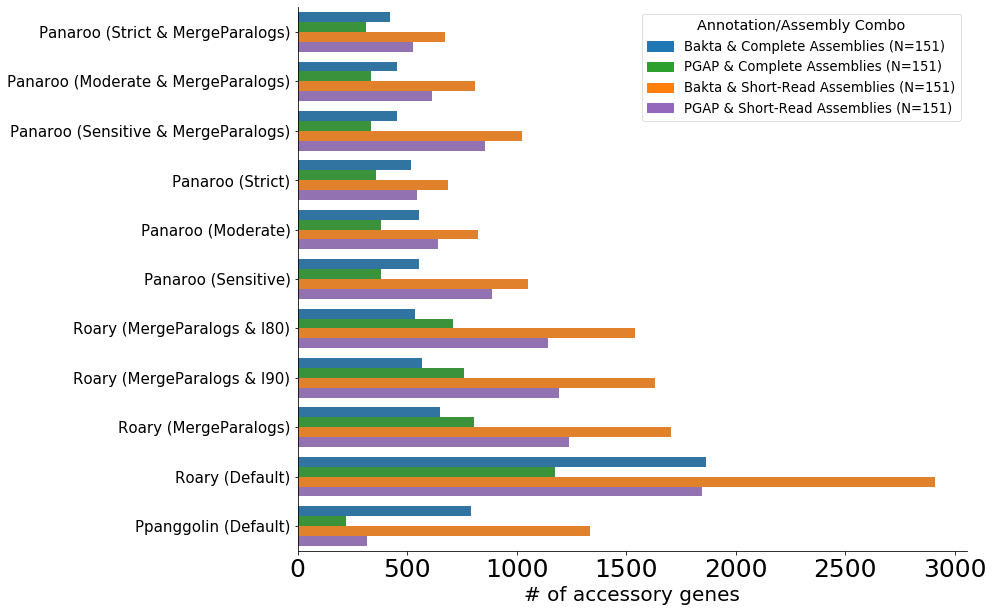

In [36]:
fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

sns.set_context("paper", font_scale=1.5)

hue_orderToPlot = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

sns.barplot(y = "Method", x = "GeneCount", hue = "AnnoAndTech",
            data = PG_Merged_Stats_LRandSR_Acc_DF,
            order = PGCombos_orderToPlot, hue_order = hue_orderToPlot_X,
            ax = axs, palette = pallete_ForPlot )

axs.set_ylabel("")
axs.set_xlabel("# of accessory genes", fontsize = 20)
axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})
axs.legend(title = "Annotation/Assembly Combo", handles=AnnoAndTech_Patches)

sns.despine()
plt.xticks(fontsize=25) #plt.xticks(labels = Plot_TickLabels, rotation=45)

#plt.savefig("Results3_Plots/3.PG.AccGeneCounts.SRvsLR.AND.BaktaVsPGAP.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.AccGeneCounts.SRvsLR.AND.BaktaVsPGAP.CombinedBarplot.svg", bbox_inches="tight")

plt.show()

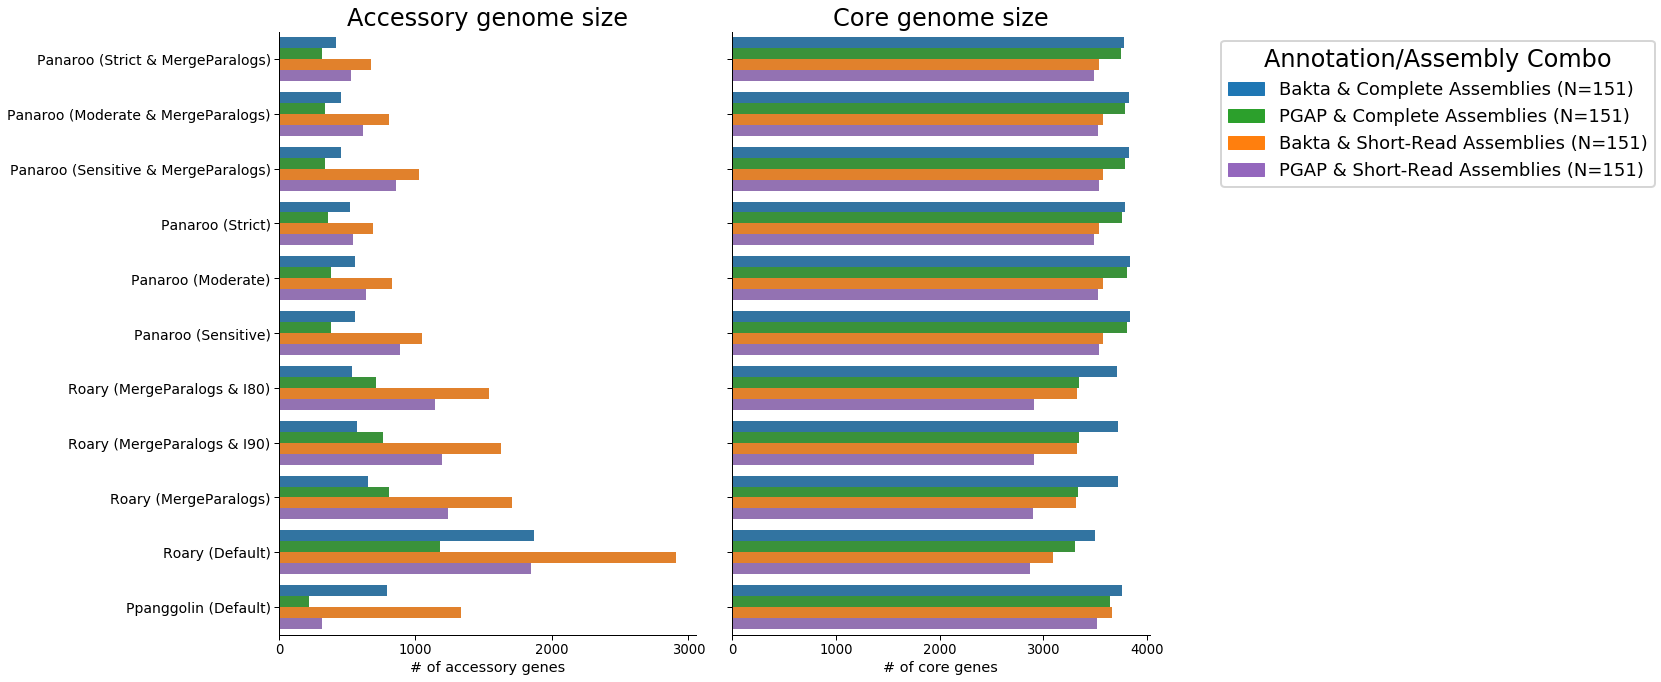

In [37]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 10), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF,
            order=PGCombos_orderToPlot, hue_order=hue_orderToPlot_X, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF,
            order=PGCombos_orderToPlot, hue_order=hue_orderToPlot_X, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=Plot_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
              bbox_to_anchor=(1.15, 1), fontsize= 18) 
axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.svg", bbox_inches="tight")

plt.show()

In [38]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].unique()

array(['Panaroo', 'Roary', 'Ppanggolin'], dtype=object)

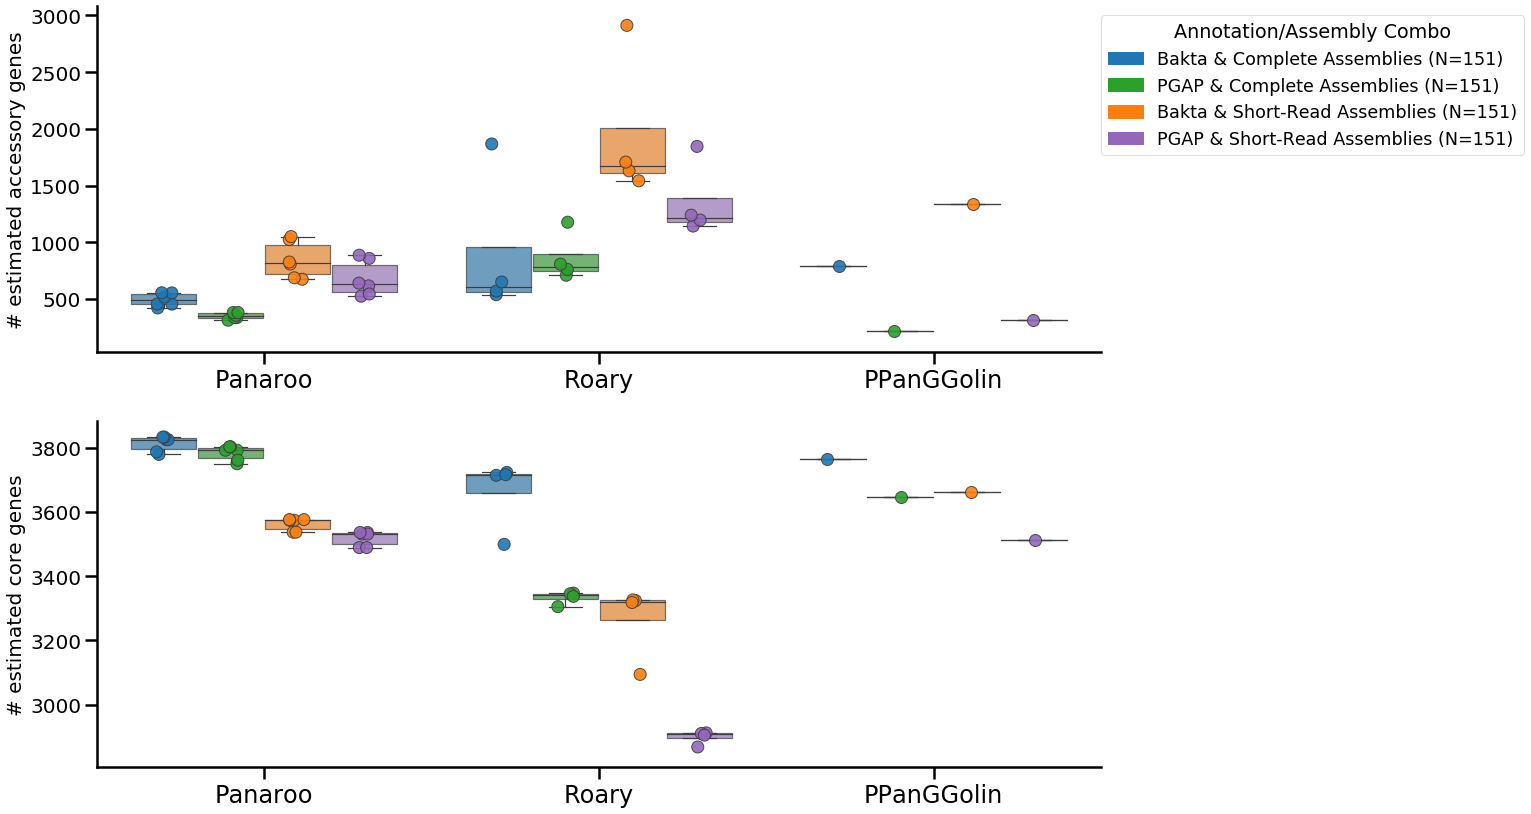

In [39]:

AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                    "Bakta-ShortRead": "#ff7f0e",
                    "PGAP-LongRead": "#2ca02c",
                    "PGAP-ShortRead": "#9467bd" }


fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)
#sns.set_context("poster")
sns.set_context("paper", font_scale=2)

ToolsOrder = ['Panaroo', 'Roary', 'Ppanggolin']


sns.stripplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Acc_DF,
              linewidth=1, size = 12, order = ToolsOrder,
              palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2, 
              alpha=0.9, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Acc_DF,
            fliersize=0, order = ToolsOrder, 
            palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2,
            ax= axs[0], boxprops=dict(alpha=0.7) )


sns.stripplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Core_DF,
              linewidth=1, size = 12, order = ToolsOrder,
              palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2, 
              alpha=0.9, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Core_DF,
            fliersize=0,  order = ToolsOrder, 
            palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2,
            ax= axs[1], boxprops=dict(alpha=0.7) )

axs[0].legend(title = "Annotation/Assembly Combo",
              handles = AnnoAndTech_Patches, bbox_to_anchor=(1.43, 1))
axs[1].get_legend().remove()

axs[0].set_xlabel("")
axs[1].set_xlabel("")

axs[0].set_ylabel("# estimated accessory genes", fontsize=20)
axs[1].set_ylabel("# estimated core genes", fontsize=20)

axs[0].set_xticklabels(labels = ["Panaroo", "Roary", "PPanGGolin"], fontsize = 24)
axs[1].set_xticklabels(labels = ["Panaroo", "Roary", "PPanGGolin"], fontsize = 24)

axs[0].set_yticklabels(axs[0].get_yticks().astype(int), fontsize=20)
axs[1].set_yticklabels(axs[1].get_yticks().astype(int), fontsize=20)

sns.despine()

#plt.savefig("Results3_Plots/3.PG.Counts.OverallCounts.Boxplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.OverallCounts.Boxplots.svg", bbox_inches="tight")

plt.show()

In [40]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Total genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   11.0  4425.000000  326.088638  4200.0  4280.5  4305.0  4387.5  5366.0
          PGAP    11.0  4132.636364  144.998119  3866.0  4084.5  4128.0  4164.0  4482.0
ShortRead Bakta   11.0  4754.000000  513.164496  4211.0  4391.0  4626.0  4977.0  6006.0
          PGAP    11.0  4184.363636  241.696617  3829.0  4044.0  4144.0  4282.5  4713.0

In [41]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Accessory genes"].describe()  

count         mean         std    min    25%     50%     75%     max
SeqType   Anno                                                                       
LongRead  Bakta   11.0   670.636364  409.824907  421.0  487.0   554.0   610.0  1867.0
          PGAP    11.0   525.272727  295.514159  220.0  336.0   381.0   735.0  1177.0
ShortRead Bakta   11.0  1290.454545  656.120471  674.0  817.0  1050.0  1586.0  2912.0
          PGAP    11.0   891.545455  437.450195  315.0  580.0   858.0  1169.5  1845.0

In [42]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Core genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   11.0  3754.363636   96.647062  3499.0  3719.5  3779.0  3825.0  3833.0
          PGAP    11.0  3607.363636  221.656163  3305.0  3346.0  3750.0  3792.0  3803.0
ShortRead Bakta   11.0  3463.545455  172.164087  3094.0  3325.0  3537.0  3575.0  3663.0
          PGAP    11.0  3292.818182  313.061917  2868.0  2911.0  3489.0  3531.0  3536.0

In [43]:
#PG_WideSumm_DF.to_csv("Results3_Plots/PG.LRvsSR.BaktaAnno.tsv", sep="\t", index= False)  

In [44]:
#PG_Merged_Stats_LRandSR_DF.to_csv("Results3_Plots/PG.LRvsSR.BaktaAnno.MergedStats.tsv", sep="\t", index= False)  

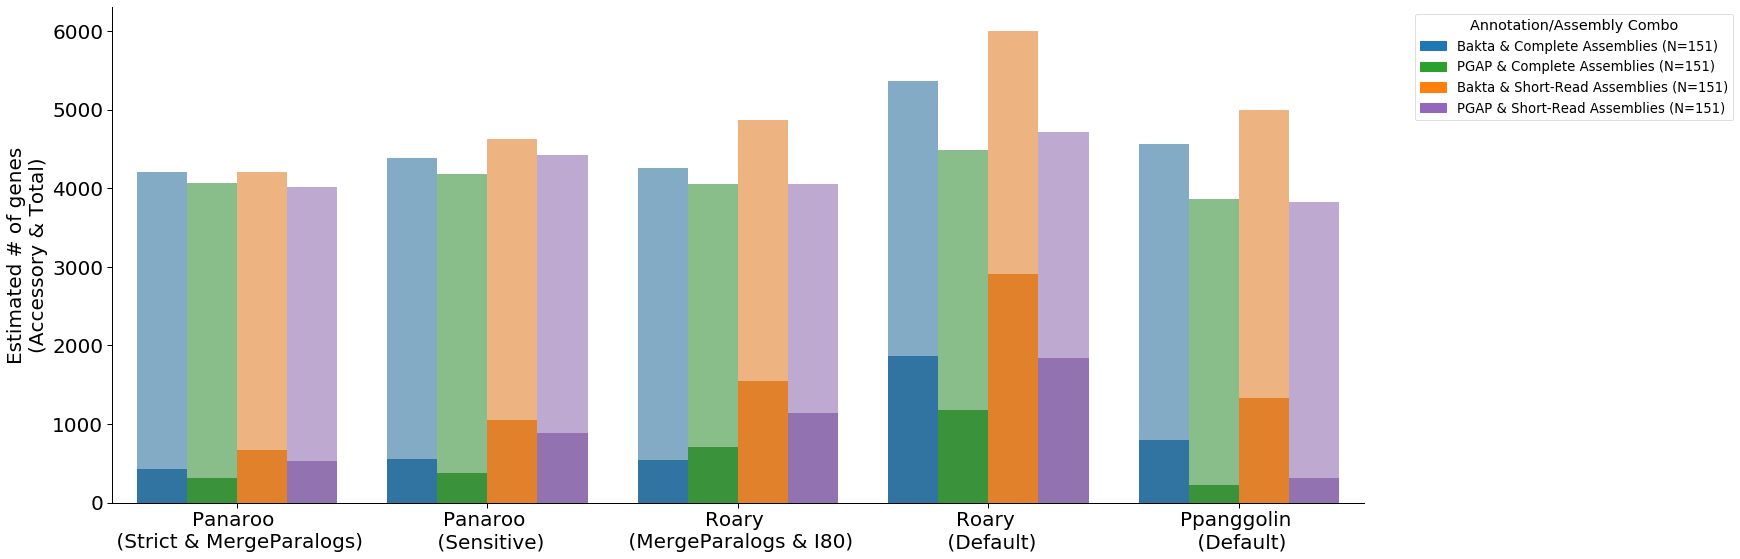

In [45]:
# Set the context for the plot
sns.set_context("paper", font_scale=1.5)
#sns.set_context("poster")

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80', 'Roary_Default', 'Ppanggolin_Default',]

Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Sensitive)',  'Roary \n (MergeParalogs & I80)', 'Roary \n (Default)', 'Ppanggolin \n (Default)',]

# Create a subplot
fig, ax = plt.subplots(figsize=(25, 8))

# Create the barplot
sns.barplot(x = "Method", y="GeneCount", hue="AnnoAndTech",
            data=PG_Merged_Stats_LRandSR_Acc_DF, order=orderToPlot_X,
            hue_order=hue_orderToPlot_V2, ax=ax, palette=pallete_ForPlot)

sns.barplot(x = "Method", y = "GeneCount", hue = "AnnoAndTech",
            data = PG_Merged_Stats_LRandSR_Pangenome_DF, order = orderToPlot_X,
            hue_order = hue_orderToPlot_V2, alpha = 0.6, ax = ax, palette = pallete_ForPlot )  

# Set the y-tick labels
Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Sensitive)',
                   'Roary \n (MergeParalogs & I80)', 'Roary \n (Default)', 'Ppanggolin \n (Default)',]

ax.set_xticklabels(labels=Plot_TickLabels, rotation=0, fontdict={"fontsize": 20})

# Set the x-axis label
ax.set_ylabel("Estimated # of genes\n(Accessory & Total)", fontsize=20)

# Set the ylabel to empty since it's removed in your original code
ax.set_xlabel("")

# Optionally, you can add a legend if needed
ax.legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
          bbox_to_anchor=(1.3, 1))


#ax.get_legend().remove()

ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=20)

# Adjust the layout and remove the right and top spines
plt.tight_layout()
sns.despine()

#plt.savefig("Results3_Plots/3.PG.Counts.SelectedToolParams.Barplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.SelectedToolParams.Barplots.svg", bbox_inches="tight")

# Display the plot
plt.show()

# Viz Explore - V2

In [46]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [47]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].value_counts()

Panaroo       24
Roary         16
Ppanggolin     4
Name: PangenomeTool, dtype: int64

In [48]:
Tools_hue_Color_Dict = { "Panaroo": "#1f77b4",
                    "Roary": "#ff7f0e",
                    "Ppanggolin": "#2ca02c" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


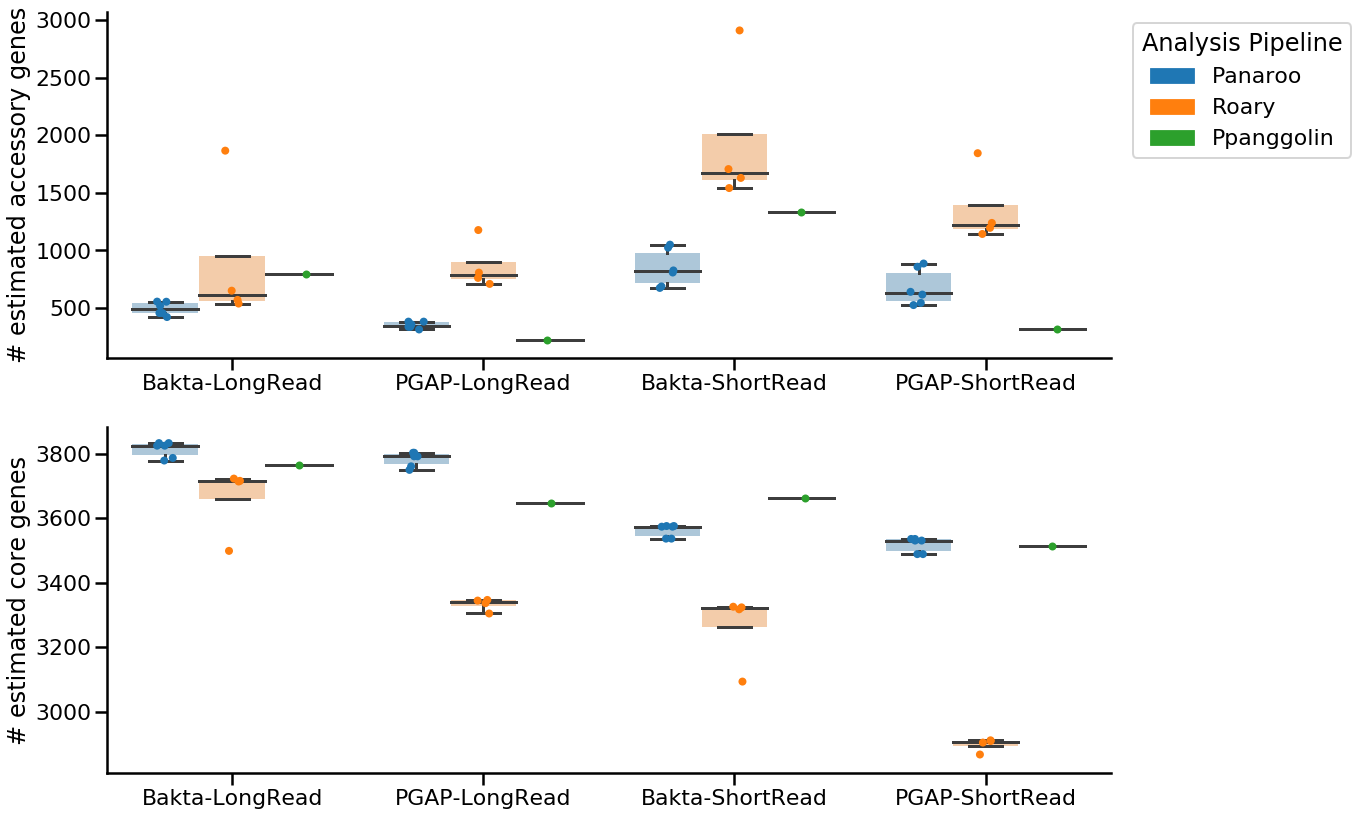

In [49]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
            hue_order = hue_Order_Tools, order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
            hue_order = hue_Order_Tools, order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.savefig("Results3_Plots/3.PG.Counts.ColorByTool.Barplots.V2.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots/3.PG.Counts.ColorByTool.Barplots.V2.svg", bbox_inches="tight")
plt.show()

In [50]:
# # Set the context for the plot
# #sns.set_context("paper", font_scale=1.5)
# sns.set_context("poster")

# # Create a subplot
# fig, axs = plt.subplots(2, 1, figsize= (12, 14), sharey = False)


# sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#               data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
#               order = Order_AnnoAndType,
#               palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
#               alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools, order = Order_AnnoAndType, 
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0), 
#             medianprops=dict(color='red', linewidth=1.5),
#             width=.6)

# sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#               data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
#               order = Order_AnnoAndType,
#               palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
#               alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.3) )

# axs[0].set_xlabel(""), axs[1].set_xlabel("")
# axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

# axs[0].legend(title = "Analysis Pipeline",
#               handles=ToolPatches_List,
#               bbox_to_anchor=(1.25, 1))
# axs[1].get_legend().remove()

# sns.despine()

# #plt.savefig("Results3_Plots/3.PG.Counts.ColorByTool.Barplots.V2.png", dpi = 300, bbox_inches="tight")
# #plt.savefig("Results3_Plots/3.PG.Counts.ColorByTool.Barplots.V2.svg", bbox_inches="tight")
# plt.show()

In [51]:
#PG_WideSumm_DF.head(4)

In [52]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Total genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   11.0  4425.000000  326.088638  4200.0  4280.5  4305.0  4387.5  5366.0
          PGAP    11.0  4132.636364  144.998119  3866.0  4084.5  4128.0  4164.0  4482.0
ShortRead Bakta   11.0  4754.000000  513.164496  4211.0  4391.0  4626.0  4977.0  6006.0
          PGAP    11.0  4184.363636  241.696617  3829.0  4044.0  4144.0  4282.5  4713.0

In [53]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Accessory genes"].describe()  

count         mean         std    min    25%     50%     75%     max
SeqType   Anno                                                                       
LongRead  Bakta   11.0   670.636364  409.824907  421.0  487.0   554.0   610.0  1867.0
          PGAP    11.0   525.272727  295.514159  220.0  336.0   381.0   735.0  1177.0
ShortRead Bakta   11.0  1290.454545  656.120471  674.0  817.0  1050.0  1586.0  2912.0
          PGAP    11.0   891.545455  437.450195  315.0  580.0   858.0  1169.5  1845.0

In [54]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Core genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   11.0  3754.363636   96.647062  3499.0  3719.5  3779.0  3825.0  3833.0
          PGAP    11.0  3607.363636  221.656163  3305.0  3346.0  3750.0  3792.0  3803.0
ShortRead Bakta   11.0  3463.545455  172.164087  3094.0  3325.0  3537.0  3575.0  3663.0
          PGAP    11.0  3292.818182  313.061917  2868.0  2911.0  3489.0  3531.0  3536.0

In [55]:
PG_WideSumm_DF.groupby(["SeqType", "Anno", "PangenomeTool"])["Core genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                          
LongRead  Bakta Panaroo          6.0  3813.666667   24.155055  3779.0  3796.50  3825.0  3831.00  3833.0
                Ppanggolin       1.0  3764.000000         NaN  3764.0  3764.00  3764.0  3764.00  3764.0
                Roary            4.0  3663.000000  109.401402  3499.0  3660.25  3715.0  3717.75  3723.0
          PGAP  Panaroo          6.0  3783.500000   22.509998  3750.0  3768.75  3792.0  3800.25  3803.0
                Ppanggolin       1.0  3646.000000         NaN  3646.0  3646.00  3646.0  3646.00  3646.0
                Roary            4.0  3333.500000   19.485037  3305.0  3329.00  3341.0  3345.50  3347.0
ShortRead Bakta Panaroo          6.0  3562.333333   19.643489  3537.0  3546.25  3574.0  3575.50  3576.0
                Ppanggolin       1.0  3663.000000         NaN  3663.0  3663.00  3663.0  3663.00  3663.0
                Roary            4.0  3265.500000  114.383857  3094.0  3262.00  3321.0  3324.50  3326.0
          PGAP  Panaroo          6.0  3518.666667   23.088237  3489.0  3499.50  3531.0  3534.75  3536.0
                Ppanggolin       1.0  3514.000000         NaN  3514.0  3514.00  3514.0  3514.00  3514.0
                Roary            4.0  2898.750000   20.710303  2868.0  2895.75  2907.5  2910.50  2912.0

In [56]:
PG_WideSumm_DF.groupby(["SeqType", "Anno", "PangenomeTool"])["Accessory genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                          
LongRead  Bakta Panaroo          6.0   493.166667   56.897862   421.0   455.25   487.0   545.00   555.0
                Ppanggolin       1.0   793.000000         NaN   793.0   793.00   793.0   793.00   793.0
                Roary            4.0   906.250000  642.229645   538.0   562.00   610.0   954.25  1867.0
          PGAP  Panaroo          6.0   350.666667   27.310560   313.0   336.00   346.5   375.00   381.0
                Ppanggolin       1.0   220.000000         NaN   220.0   220.00   220.0   220.00   220.0
                Roary            4.0   863.500000  212.799593   709.0   748.00   784.0   899.50  1177.0
ShortRead Bakta Panaroo          6.0   844.833333  161.245672   674.0   717.25   817.0   974.50  1050.0
                Ppanggolin       1.0  1335.000000         NaN  1335.0  1335.00  1335.0  1335.00  1335.0
                Roary            4.0  1947.750000  646.358195  1542.0  1608.00  1668.5  2008.25  2912.0
          PGAP  Panaroo          6.0   678.166667  156.407694   525.0   562.00   628.0   803.50   886.0
                Ppanggolin       1.0   315.000000         NaN   315.0   315.00   315.0   315.00   315.0
                Roary            4.0  1355.750000  328.521308  1143.0  1182.75  1217.5  1390.50  1845.0

# Visualize differences in CDS & Pseudogene counts - Bakta vs PGAP

## Part 1: Parse PGAPvsBakta comparison TSV

In [57]:
annot_comparison_df = pd.read_csv('Data/pgap_and_bakta_comparison_stats.151CI.tsv',
                                  sep='\t')
annot_comparison_df.shape

(151, 9)

In [58]:
annot_comparison_df.head(4)

,Isolate,Bakta_proteincoding,Bakta_pseudogenes,Bakta_RNAgenes,Bakta_total,PGAP_proteincoding,PGAP_pseudogenes,PGAP_RNAgenes,PGAP_total
0,N0072,4041,11,71,4123,3903,356,49,4308
1,N0153,4028,14,71,4113,3872,388,49,4309
2,TB3113,4077,7,72,4156,3916,382,49,4347
3,TB1236,4065,8,72,4145,3925,370,49,4344


## Part 2: Calculate table of summary stats (PGAP vs Bakta)

In [59]:
#The following code calculates the median and IQR for each feature type for both PGAP and Bakta.

#function to calculate IQR
def calculate_iqr(series):
    return series.quantile(0.75) - series.quantile(0.25)

feature_types = ['proteincoding', 'pseudogenes', 'RNAgenes', 'total']

#initializing a dictionary to hold the summary statistics
summary_stats = {'Feature': [],
                 'PGAP_Median': [], 'PGAP_IQR': [], 'PGAP_Q1': [], 'PGAP_Q3': [],
                 'Bakta_Median': [], 'Bakta_IQR': [], 'Bakta_Q1': [], 'Bakta_Q3': [],}

for feature in feature_types:
    summary_stats['Feature'].append(feature.capitalize())
    summary_stats['PGAP_Median'].append(annot_comparison_df[f'PGAP_{feature}'].median())
    summary_stats['PGAP_IQR'].append(calculate_iqr(annot_comparison_df[f'PGAP_{feature}']))
    summary_stats['PGAP_Q1'].append(annot_comparison_df[f'PGAP_{feature}'].quantile(0.25))
    summary_stats['PGAP_Q3'].append(annot_comparison_df[f'PGAP_{feature}'].quantile(0.75))

    summary_stats['Bakta_Median'].append(annot_comparison_df[f'Bakta_{feature}'].median())
    summary_stats['Bakta_IQR'].append(calculate_iqr(annot_comparison_df[f'Bakta_{feature}']))
    summary_stats['Bakta_Q1'].append(annot_comparison_df[f'Bakta_{feature}'].quantile(0.25))
    summary_stats['Bakta_Q3'].append(annot_comparison_df[f'Bakta_{feature}'].quantile(0.75))

summary_df = pd.DataFrame(summary_stats)

summary_df


,Feature,PGAP_Median,PGAP_IQR,PGAP_Q1,PGAP_Q3,Bakta_Median,Bakta_IQR,Bakta_Q1,Bakta_Q3
0,Proteincoding,3919.0,30.0,3900.0,3930.0,4067.0,22.5,4057.0,4079.5
1,Pseudogenes,376.0,57.0,339.0,396.0,9.0,3.0,7.0,10.0
2,Rnagenes,49.0,0.0,49.0,49.0,72.0,1.0,71.0,72.0
3,Total,4340.0,35.5,4320.0,4355.5,4147.0,22.5,4138.0,4160.5


## Part 3: Generate boxplots comparing annotation types - PGAP vs Bakta

In [60]:
!mkdir Results3_Plots/

mkdir: cannot create directory ‘Results3_Plots/’: File exists


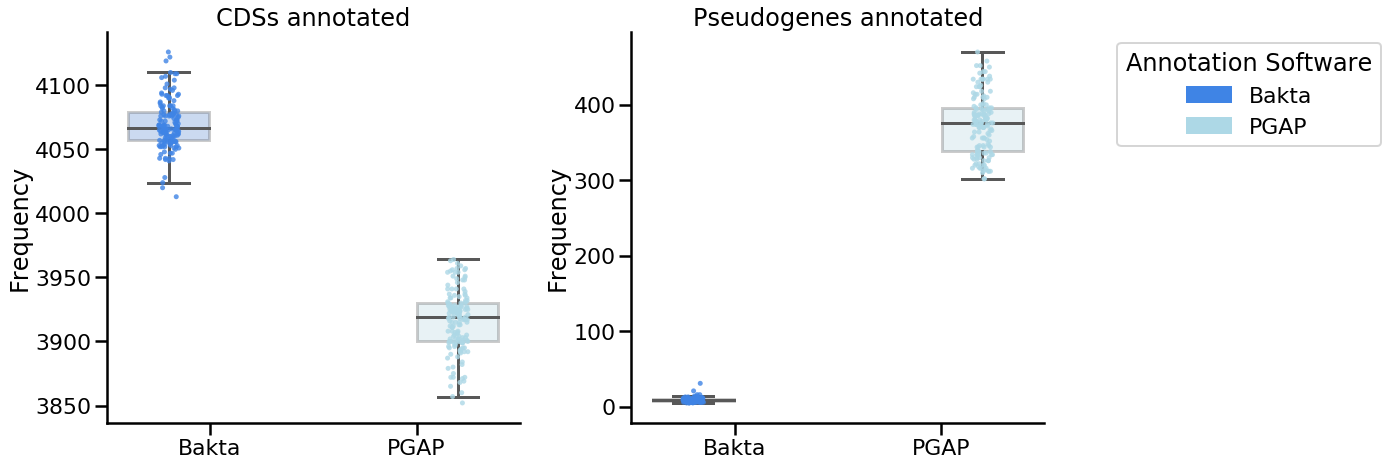

In [61]:
sns.set_context("poster")

#melting dataframe to long format for use with seaborn's boxplot
df_melted = annot_comparison_df.melt(id_vars='Isolate', var_name='Annotation_Type', value_name='Count')

#splitting 'Annotation_Type' into 'Software' and 'Feature' for grouping in the plot
df_melted[['Software', 'Feature']] = df_melted['Annotation_Type'].str.split('_', expand=True)

df_melted = df_melted[~df_melted['Feature'].str.contains('total', case=False)]
df_melted["Feature"] = df_melted["Feature"].replace("proteincoding", "CDSs").replace("RNAgenes", "RNAs").replace("pseudogenes", "Pseudogenes")

df_melted = df_melted.query("Feature != 'RNAs'")

features = df_melted['Feature'].unique()

#creating a subplot for each feature type with independent y-axes
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 7), sharey=False)

pallete_ForPlot = ["#3F84E5", "#ADD8E6"]


#plotting each feature type in its own subplot with seaborn boxplot and stripplot
for ax, feature in zip(axes, features):
    feature_data = df_melted[df_melted['Feature'] == feature]
    sns.boxplot(
        data=feature_data, 
        x='Software', y='Count', hue='Software', palette=pallete_ForPlot, boxprops=dict(alpha=.3), fliersize=0, ax=ax, 
    )
    sns.stripplot(
        data=feature_data,
        x='Software', y='Count', hue='Software', jitter=True, marker='o', alpha=0.8, edgecolor='gray',
        ax=ax, dodge=True, palette = pallete_ForPlot
    )
    ax.set_title(f'{feature} annotated')
    #ax.set_xlabel('Feature Type')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    sns.despine(ax=ax)

    #only show the legend for the last plot
    if ax != axes[-1]:
        ax.get_legend().remove()

#axes[-1].legend(title='Annotation Software', loc='upper right')

Bakta_patch = mpatches.Patch(color="#3F84E5", label='Bakta')
PGAP_patch = mpatches.Patch(color = "#ADD8E6", label='PGAP')

ax.legend(title = "Annotation Software", handles=[Bakta_patch, PGAP_patch], bbox_to_anchor=(1.15, 1)) 


#adjusting layout to prevent overlap
plt.tight_layout()

plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.2Boxplots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.2Boxplots.svg", bbox_inches="tight")

plt.show()

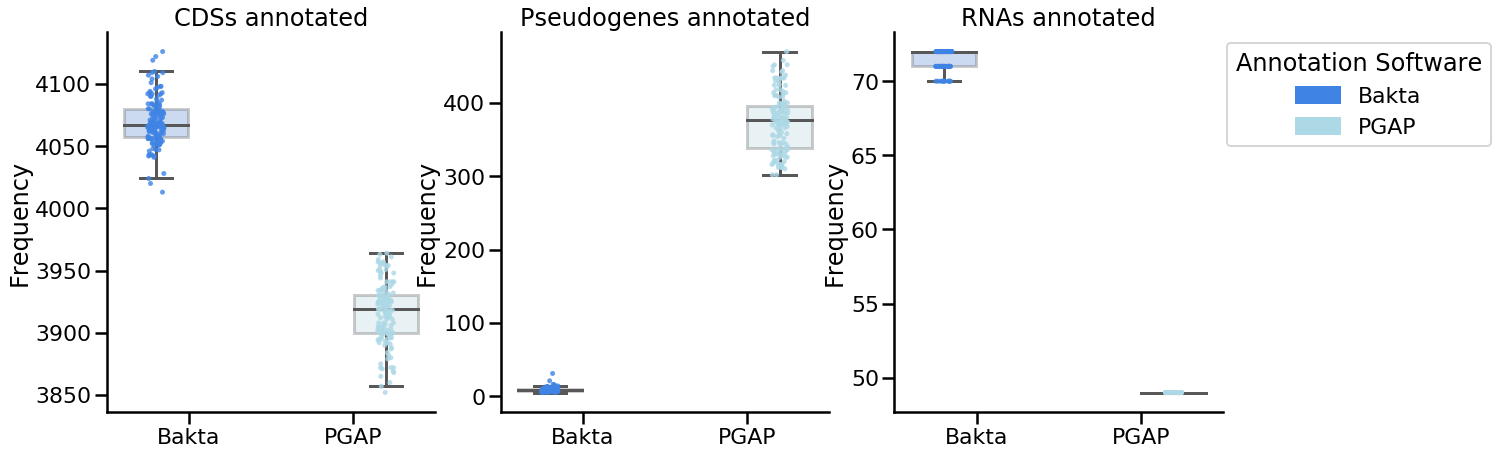

In [62]:
sns.set_context("poster")

#melting dataframe to long format for use with seaborn's boxplot
df_melted = annot_comparison_df.melt(id_vars='Isolate', var_name='Annotation_Type', value_name='Count')

#splitting 'Annotation_Type' into 'Software' and 'Feature' for grouping in the plot
df_melted[['Software', 'Feature']] = df_melted['Annotation_Type'].str.split('_', expand=True)

df_melted = df_melted[~df_melted['Feature'].str.contains('total', case=False)]
df_melted["Feature"] = df_melted["Feature"].replace("proteincoding", "CDSs").replace("RNAgenes", "RNAs").replace("pseudogenes", "Pseudogenes")


features = df_melted['Feature'].unique()

#creating a subplot for each feature type with independent y-axes
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 7), sharey=False)

pallete_ForPlot = ["#3F84E5", "#ADD8E6"]


#plotting each feature type in its own subplot with seaborn boxplot and stripplot
for ax, feature in zip(axes, features):
    feature_data = df_melted[df_melted['Feature'] == feature]
    sns.boxplot(
        data=feature_data, 
        x='Software', y='Count', hue='Software', palette=pallete_ForPlot, boxprops=dict(alpha=.3), fliersize=0, ax=ax, 
    )
    sns.stripplot(
        data=feature_data,
        x='Software', y='Count', hue='Software', jitter=True, marker='o', alpha=0.8, edgecolor='gray',
        ax=ax, dodge=True, palette = pallete_ForPlot   
    )
    ax.set_title(f'{feature} annotated')
    #ax.set_xlabel('Feature Type')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    sns.despine(ax=ax)

    #only show the legend for the last plot
    if ax != axes[-1]:
        ax.get_legend().remove()

#axes[-1].legend(title='Annotation Software', loc='upper right')

Bakta_patch = mpatches.Patch(color="#3F84E5", label='Bakta')
PGAP_patch = mpatches.Patch(color = "#ADD8E6", label='PGAP')

ax.legend(title = "Annotation Software", handles=[Bakta_patch, PGAP_patch], bbox_to_anchor=(1.85, 1)) 

#adjusting layout to prevent overlap
#plt.tight_layout()

#plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.3Boxplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.AnnoFeatures.BaktaVsPGAP.3Boxplots.svg", bbox_inches="tight")

plt.show()

In [63]:
annot_comparison_df.head(5)

,Isolate,Bakta_proteincoding,Bakta_pseudogenes,Bakta_RNAgenes,Bakta_total,PGAP_proteincoding,PGAP_pseudogenes,PGAP_RNAgenes,PGAP_total
0,N0072,4041,11,71,4123,3903,356,49,4308
1,N0153,4028,14,71,4113,3872,388,49,4309
2,TB3113,4077,7,72,4156,3916,382,49,4347
3,TB1236,4065,8,72,4145,3925,370,49,4344
4,TB2659,4065,8,72,4145,3922,370,49,4341


In [64]:
df_melted["Feature"].value_counts()

CDSs           302
Pseudogenes    302
RNAs           302
Name: Feature, dtype: int64

In [65]:
df_melted.head(5)

,Isolate,Annotation_Type,Count,Software,Feature
0,N0072,Bakta_proteincoding,4041,Bakta,CDSs
1,N0153,Bakta_proteincoding,4028,Bakta,CDSs
2,TB3113,Bakta_proteincoding,4077,Bakta,CDSs
3,TB1236,Bakta_proteincoding,4065,Bakta,CDSs
4,TB2659,Bakta_proteincoding,4065,Bakta,CDSs


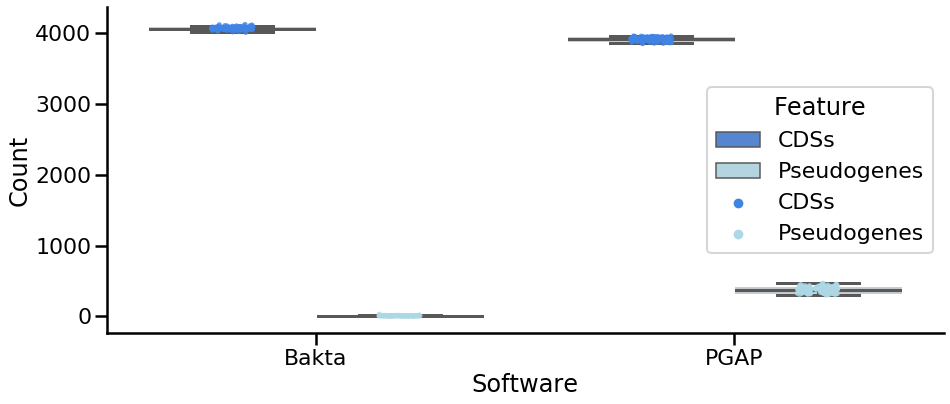

In [66]:

df_melted_CDS_Vs_Pseudo = df_melted.query("Feature != 'RNAs' ")

sns.set_context("poster")

fig, axs = plt.subplots(1, 1, figsize= (15, 6), sharey = False)
sns.boxplot(
    data = df_melted_CDS_Vs_Pseudo, 
    x='Software', y='Count', hue='Feature', palette=pallete_ForPlot,
    boxprops=dict(alpha=.3), fliersize=0, ax=axs, 
)

sns.stripplot(
    data = df_melted_CDS_Vs_Pseudo,
    x='Software', y='Count', hue='Feature', marker='o', alpha=0.8, edgecolor='gray',
    ax=axs, dodge=True, jitter=True, palette = pallete_ForPlot)

sns.despine()
plt.show()